# California Housing Price Prediction Project

## 1. Data Preprocessing

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.datasets import fetch_california_housing


In [ ]:
data = fetch_california_housing()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Target'] = data.target

### 1.1 Data Cleaning

In [ ]:
print("Missing values:")
print(df.isnull().sum())

df.drop_duplicates(inplace=True)

Missing values:
MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
Target        0
dtype: int64


### 1.2 Data Exploration

In [5]:
print("\nStatistical Summary:")
print(df.describe())


Statistical Summary:
             MedInc      HouseAge      AveRooms     AveBedrms    Population  \
count  20640.000000  20640.000000  20640.000000  20640.000000  20640.000000   
mean       3.870671     28.639486      5.429000      1.096675   1425.476744   
std        1.899822     12.585558      2.474173      0.473911   1132.462122   
min        0.499900      1.000000      0.846154      0.333333      3.000000   
25%        2.563400     18.000000      4.440716      1.006079    787.000000   
50%        3.534800     29.000000      5.229129      1.048780   1166.000000   
75%        4.743250     37.000000      6.052381      1.099526   1725.000000   
max       15.000100     52.000000    141.909091     34.066667  35682.000000   

           AveOccup      Latitude     Longitude        Target  
count  20640.000000  20640.000000  20640.000000  20640.000000  
mean       3.070655     35.631861   -119.569704      2.068558  
std       10.386050      2.135952      2.003532      1.153956  
min       

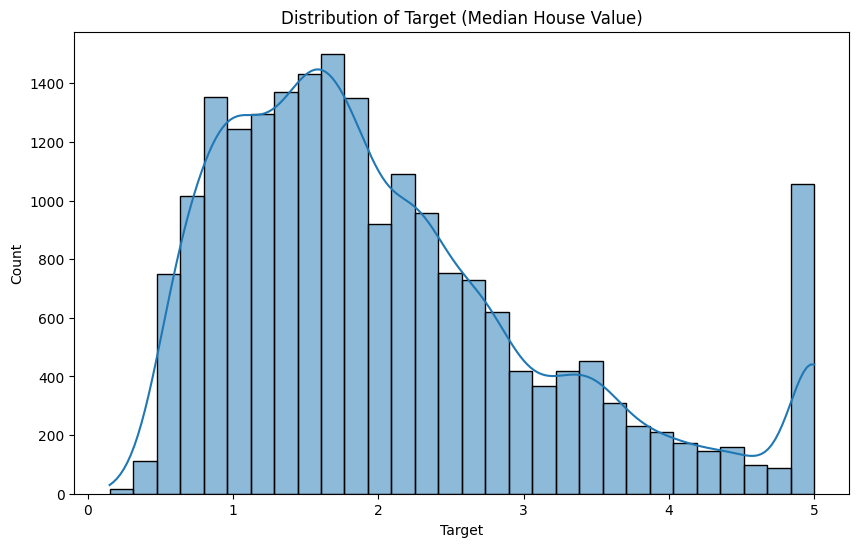

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(df['Target'], bins=30, kde=True)
plt.title("Distribution of Target (Median House Value)")
plt.show()

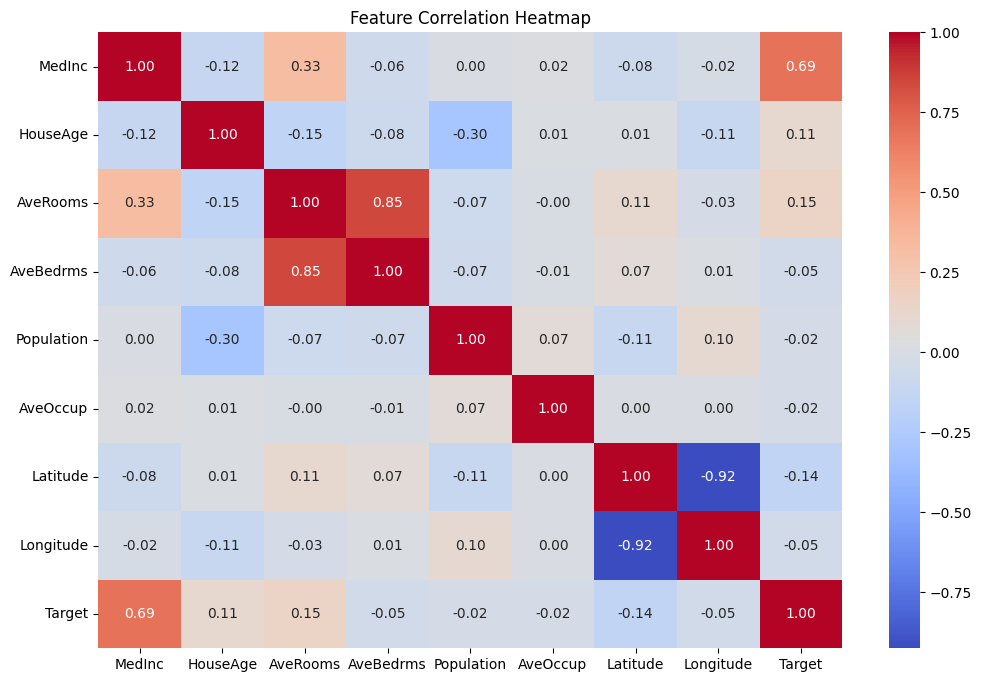

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

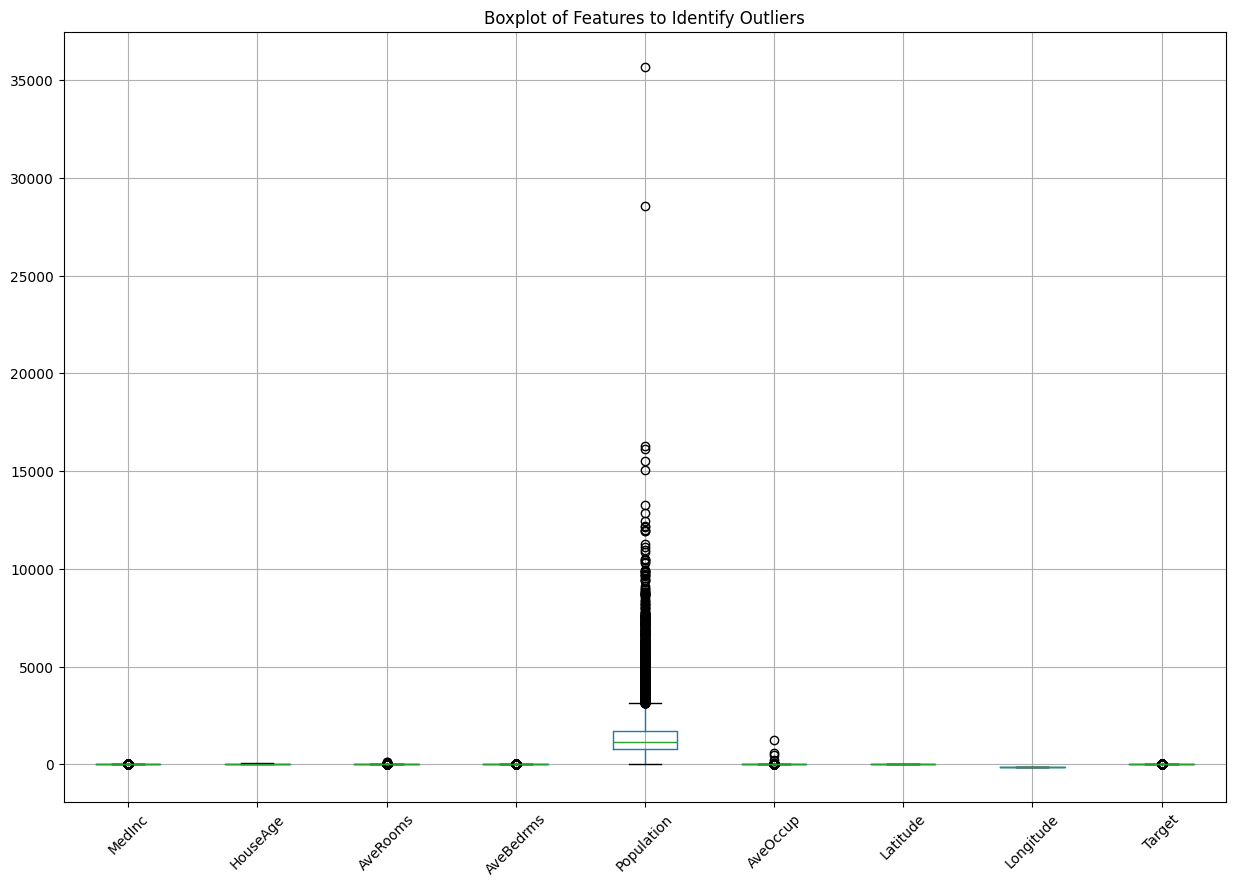

In [ ]:
plt.figure(figsize=(15, 10))
df.boxplot(rot=45)
plt.title("Boxplot of Features to Identify Outliers")
plt.xticks(rotation=45)
plt.show()

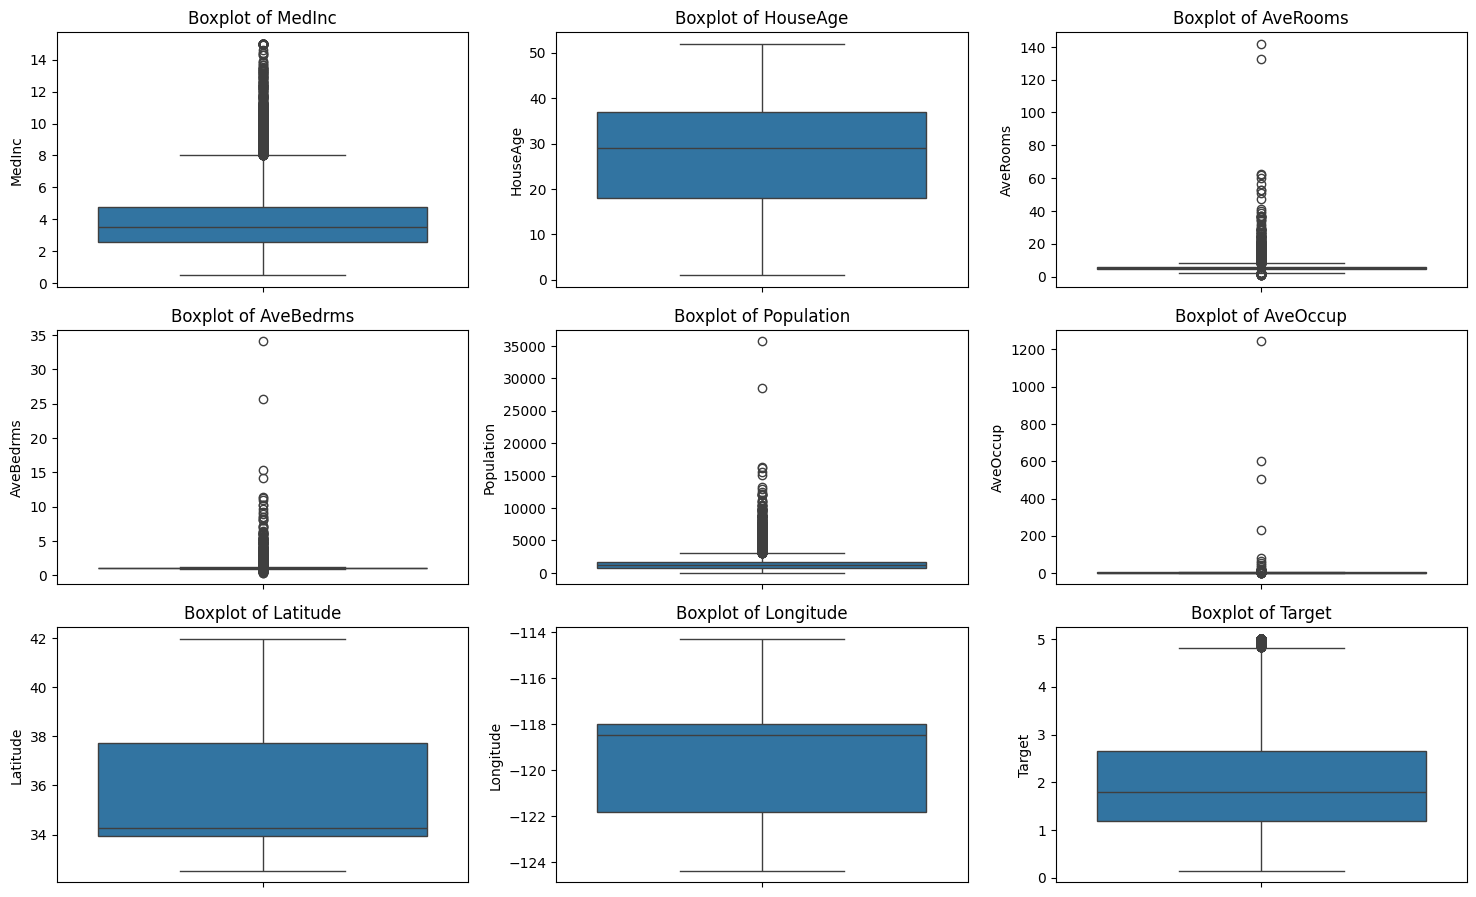

In [ ]:
num_features = df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(15, 12))
for i, col in enumerate(num_features, 1):
    plt.subplot(4, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

### 1.3 Data Transformation

One-Hot Encoding for Linear Regression

In [ ]:
categorical_cols = df.select_dtypes(include=['object']).columns
df_ohe = df.copy()
df_ohe = pd.get_dummies(df_ohe, columns=categorical_cols, drop_first=True)

Label Encoding for Tree-Based Models

In [ ]:
df_label = df.copy()
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    df_label[col] = le.fit_transform(df_label[col])
    label_encoders[col] = le

Standardising the dataset

In [14]:
scaler = StandardScaler()

df_label_scaled = df_label.copy()
df_label_scaled[df_label.columns.difference(categorical_cols)] = scaler.fit_transform(
    df_label[df_label.columns.difference(categorical_cols)]
)

df_ohe_scaled = pd.DataFrame(scaler.fit_transform(df_ohe), columns=df_ohe.columns)

### 1.4 Data Separation

In [15]:
def split_data(df):
    X = df.drop(columns=["Target"])
    y = df["Target"]
    return train_test_split(X, y, test_size=0.2, random_state=42)

X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe = split_data(df_ohe_scaled)  #linear regression
X_train_label, X_test_label, y_train_label, y_test_label = split_data(df_label_scaled)  #tree based


## 2. Modeling

### 2.1 Model selection

In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=50, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(random_state=42),
}

### 2.2 Model training

In [ ]:
trained_models = {}

for name, model in models.items():
    print(f"Training {name}...")

    if name == "Linear Regression":
        X_train, X_test, y_train, y_test = X_train_ohe, X_test_ohe, y_train_ohe, y_test_ohe
    else:
        X_train, X_test, y_train, y_test = X_train_label, X_test_label, y_train_label, y_test_label

    model.fit(X_train, y_train) 
    trained_models[name] = model


Training Linear Regression...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...


### 2.3 Model optimisation

tuning hyperparameters using GridSearchCV for the Decision Tree, Random Forest, and Gradient Boosting models.

In [ ]:
param_grid = {
    "Decision Tree": {"max_depth": list(range(1, 21)) },
    "Random Forest": {"n_estimators": list(range(10, 210, 10)), "max_depth": list(range(1, 21))},
    "Gradient Boosting": {"n_estimators": list(range(10, 210, 10)), "learning_rate": [0.01, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9]}
}

best_models = {}

for name, model in models.items():
    if name == "Linear Regression":
        best_models[name] = model
        continue #skip linear regression

    print(f"Tuning hyperparameters for {name}...")
    
    grid_search = GridSearchCV(model, param_grid[name], cv=5, scoring="r2", n_jobs=-1)
    grid_search.fit(X_train_label, y_train_label)
    
    best_models[name] = grid_search.best_estimator_
    print(f"Best params for {name}: {grid_search.best_params_}")

Tuning hyperparameters for Decision Tree...
Best params for Decision Tree: {'max_depth': 9}
Tuning hyperparameters for Random Forest...
Best params for Random Forest: {'max_depth': 20, 'n_estimators': 170}
Tuning hyperparameters for Gradient Boosting...
Best params for Gradient Boosting: {'learning_rate': 0.3, 'n_estimators': 200}


## 3. Model Evaluation

### 3.1 Evaluation metrics

To compare model performance, we will calculate:

- **Mean Squared Error (MSE)**: Measures the average squared difference between predictions and actual values.
- **Root Mean Squared Error (RMSE)**: The square root of MSE, making it more interpretable.
- **Mean Absolute Error (MAE)**: Measures the average absolute error.
- **R² Score**: Explains the variance in the target variable explained by the model.

In [ ]:
results = {}

for name, model in best_models.items():
    print(f"Evaluating {name}...")

    if name == "Linear Regression":
        X_test, y_test = X_test_ohe, y_test_ohe
    else:
        X_test, y_test = X_test_label, y_test_label

    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {"MSE": mse, "RMSE": rmse, "MAE": mae, "R²": r2}

results_df = pd.DataFrame(results).T
print(results_df)

Evaluating Linear Regression...
Evaluating Decision Tree...
Evaluating Random Forest...
Evaluating Gradient Boosting...
                        MSE      RMSE       MAE        R²
Linear Regression  0.417477  0.646125  0.462074  0.575788
Decision Tree      0.308100  0.555068  0.377256  0.686929
Random Forest      0.192012  0.438191  0.283968  0.804891
Gradient Boosting  0.178146  0.422074  0.283736  0.818980


### 3.2 Visualisation

- **Residual plots**: To check for patterns in errors.
- **Actual vs. Predicted plots**: To compare model predictions against actual values.

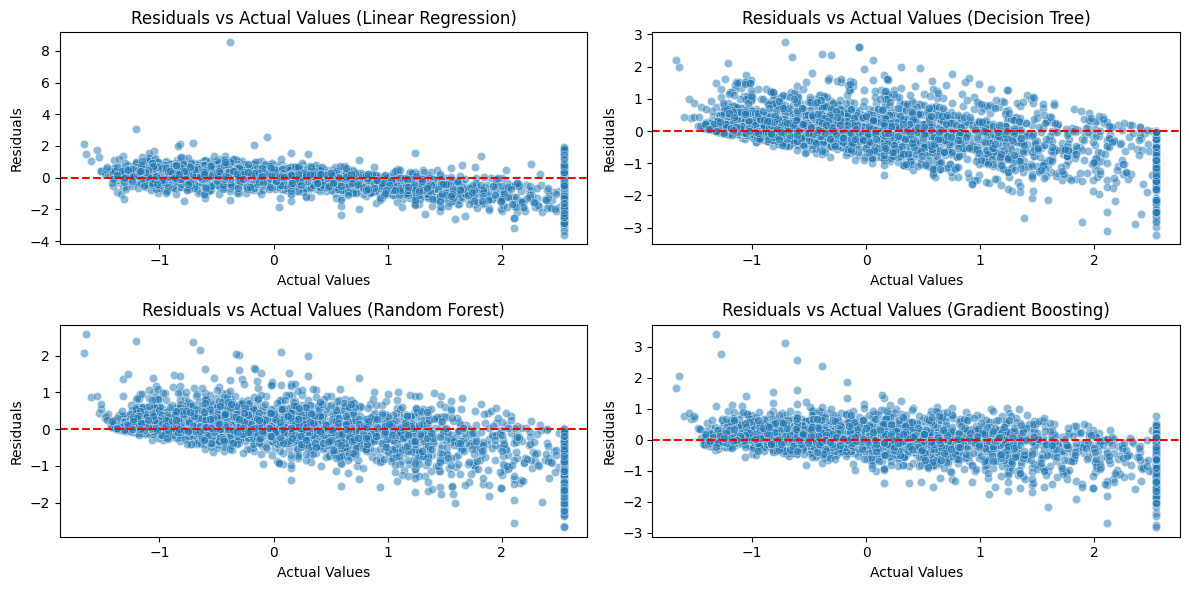

In [ ]:
plt.figure(figsize=(12, 6))

for i, (name, model) in enumerate(best_models.items()):
    plt.subplot(2, 2, i + 1)

    if name == "Linear Regression":
        X_test, y_test = X_test_ohe, y_test_ohe
    else:
        X_test, y_test = X_test_label, y_test_label

    y_pred = model.predict(X_test)

    sns.scatterplot(x=y_test, y=y_pred - y_test, alpha=0.5)
    plt.axhline(y=0, color="red", linestyle="--")
    plt.xlabel("Actual Values")
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs Actual Values ({name})")

plt.tight_layout()
plt.show()

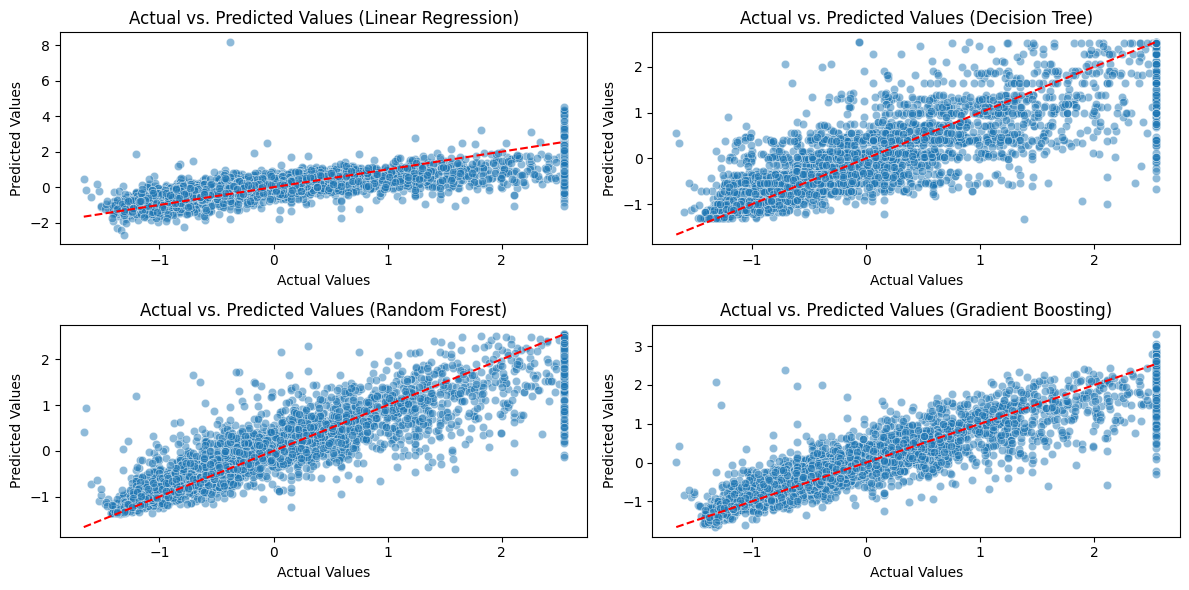

In [ ]:
plt.figure(figsize=(12, 6))

for i, (name, model) in enumerate(best_models.items()):
    plt.subplot(2, 2, i + 1)

    if name == "Linear Regression":
        X_test, y_test = X_test_ohe, y_test_ohe
    else:
        X_test, y_test = X_test_label, y_test_label

    y_pred = model.predict(X_test)

    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color="red", linestyle="--")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title(f"Actual vs. Predicted Values ({name})")

plt.tight_layout()
plt.show()

## 4. Results analysis

Based on our evaluation metrics:

- Which model performed best?
- Why did this model outperform others?
- What are the trade-offs between models?

In [31]:
print("Final Model Performance Comparison:")
display(results_df)

Final Model Performance Comparison:


,MSE,RMSE,MAE,R²
Linear Regression,0.417477,0.646125,0.462074,0.575788
Decision Tree,0.308100,0.555068,0.377256,0.686929
Random Forest,0.192012,0.438191,0.283968,0.804891
Gradient Boosting,0.178146,0.422074,0.283736,0.818980


In [32]:
best_model_name = results_df["R²"].idxmax()
print(f"\n🏆 The best performing model is: {best_model_name} with an R² score of {results_df.loc[best_model_name, 'R²']:.4f}")


🏆 The best performing model is: Gradient Boosting with an R² score of 0.8190
